## Load libraries and data

In [1]:
# load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# load the data by reading the raw csv file
# use parse_dates argument to read the date column in datetime format
btc = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=['Timestamp'], usecols=['Timestamp', 'Weighted_Price'])

In [3]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


## Explore the data

In [4]:
btc.shape

(4857377, 2)

In [5]:
# check data types
btc.dtypes

Timestamp          object
Weighted_Price    float64
dtype: object

In [6]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


In [7]:
btc.tail()

,Timestamp,Weighted_Price
4857372,1617148560,58692.753339
4857373,1617148620,58693.226508
4857374,1617148680,58696.198496
4857375,1617148740,58761.866202
4857376,1617148800,58764.349363


### Check and drop null values

In [8]:
# check how many rows have non-null values
btc.notnull().sum()

Timestamp         4857377
Weighted_Price    3613769
dtype: int64

As there are over 1 million rows having null value, I'm going to drop them.

In [9]:
# drop null rows
btc = btc.dropna()

In [10]:
# check if null values are all removed
btc.isnull().values.any()

False

In [11]:
btc.shape

(3613769, 2)

In [12]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
478,1325346600,4.390000
547,1325350740,4.526411
548,1325350800,4.580000
1224,1325391360,4.580000


### Reset index

In [13]:
btc.reset_index(drop=True, inplace=True)
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
1,1325346600,4.390000
2,1325350740,4.526411
3,1325350800,4.580000
4,1325391360,4.580000


## Cleaning, transforming and visualizing

### The timestamps are in Unix time so I'm going to transform it to datetime

In [14]:
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.dtypes

Timestamp         datetime64[ns]
Weighted_Price           float64
dtype: object

In [15]:
btc.head(5)

,Timestamp,Weighted_Price
0,2011-12-31 07:52:00,4.390000
1,2011-12-31 15:50:00,4.390000
2,2011-12-31 16:59:00,4.526411
3,2011-12-31 17:00:00,4.580000
4,2012-01-01 04:16:00,4.580000


In [16]:
btc.tail(5)

,Timestamp,Weighted_Price
3613764,2021-03-30 23:56:00,58692.753339
3613765,2021-03-30 23:57:00,58693.226508
3613766,2021-03-30 23:58:00,58696.198496
3613767,2021-03-30 23:59:00,58761.866202
3613768,2021-03-31 00:00:00,58764.349363


### Plot the data

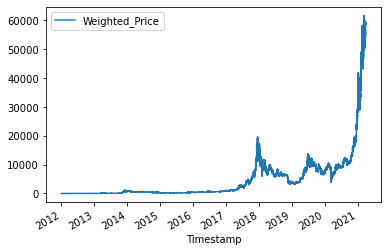

In [131]:
btc.plot(x='Timestamp', y='Weighted_Price')
plt.show()

### Downsample to daily data

In [132]:
btc.index = btc['Timestamp']
btc_daily = btc.resample('D').mean()
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [133]:
btc_daily = btc_daily.dropna()

In [134]:
btc_daily.isnull().values.any()

False

In [135]:
type(daily)

pandas.core.frame.DataFrame

In [136]:
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


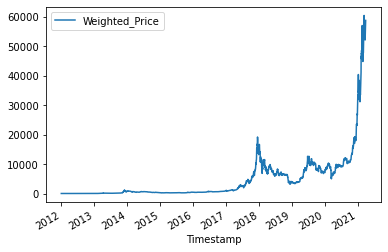

In [137]:
btc_daily.plot()

### Check if data is stationary

In [138]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

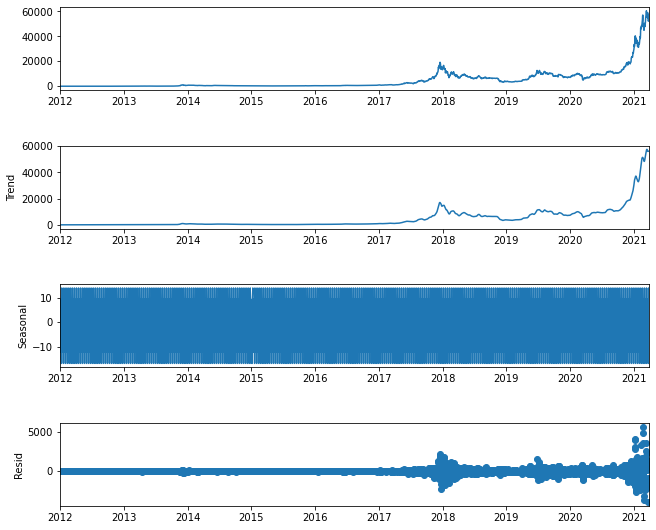

In [139]:
# Seasonal Decomposition
# observed = trend + seasonal + resid
# period(=freq) : seosonal을 볼때 주기

decomposition = sm.tsa.seasonal_decompose(btc_daily, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Does data have:  
- Trend? Increasing  
- Seasonality? No  
- Residual? Increasing

We can see that the data is non-stationarity as the average is different by time.

### Split train-test data - remove the last one month data (use this for test) and train

In [156]:
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [157]:
btc_daily.tail()

,Weighted_Price
Timestamp,
2021-03-27,55193.357260
2021-03-28,55832.958824
2021-03-29,56913.993819
2021-03-30,58346.912268
2021-03-31,58764.349363


In [158]:
# train_test_split
from sklearn.model_selection import train_test_split
train, test = train_test_split(btc_daily, test_size=(btc_daily.index > '2021-02-28').sum(), shuffle=False, random_state=42)

This will put the last one month (31 days) into test data.

In [159]:
test.head()

,Weighted_Price
Timestamp,
2021-03-01,47641.536899
2021-03-02,48617.289321
2021-03-03,50429.449016
2021-03-04,49398.250399
2021-03-05,47717.643300


### Plot the ACF and PACF on the train data

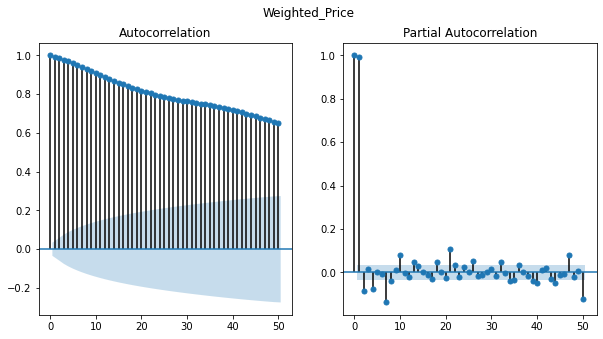

In [161]:
# Plot acf and pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Weighted_Price')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=50, ax=ax[1]);

The ACF tails off slowly and PACF cuts off after lag 1 so I'm taking (p=0, q=1) MA(1) and the data needs to be differenced.

### Taking the difference

##### 1st order differencing

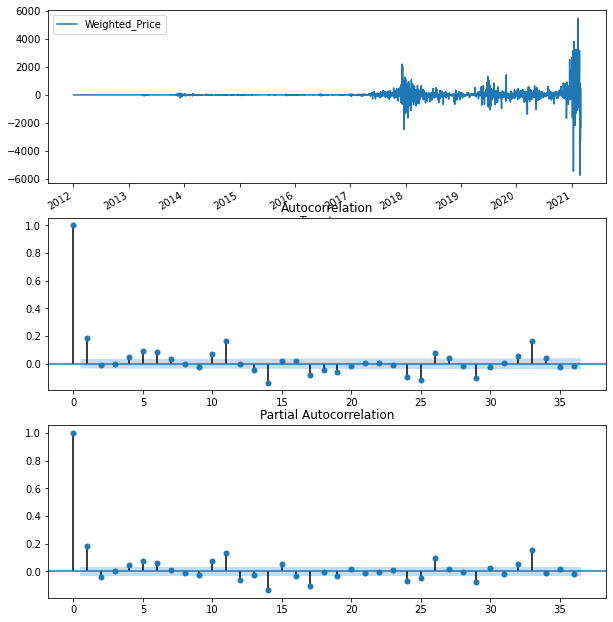

In [162]:
train_diff_1 = train.diff(periods=1).iloc[1:]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
train_diff_1.plot(ax=ax1)
plot_acf(train_diff_1, ax=ax2)
plot_pacf(train_diff_1, ax=ax3)
plt.show()

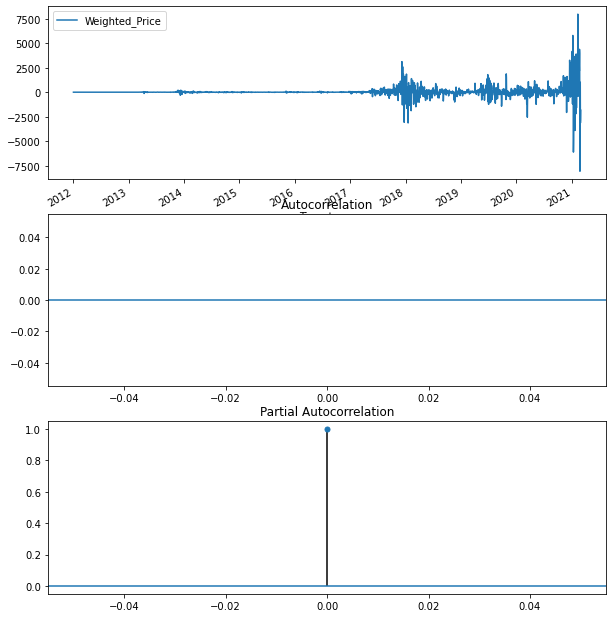

In [163]:
train_diff_2 = train.diff(periods=2).iloc[1:]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
train_diff_2.plot(ax=ax1)
plot_acf(train_diff_2, ax=ax2)
plot_pacf(train_diff_2, ax=ax3)
plt.show()

It looks stationary when taking the 1st order differencing.  
I'll take ARIMA(0, 1, 1) model.

### Apply modeling - ARIMA

In [166]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [167]:
# MA(1)
model1 = ARIMA(train.values, order=(0, 1, 1))
model1_fit = model1.fit(trend='c')
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3344
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -24133.945
Method:                       css-mle   S.D. of innovations            329.687
Date:                Tue, 12 Oct 2021   AIC                          48273.890
Time:                        22:02:56   BIC                          48292.235
Sample:                             1   HQIC                         48280.452
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2469      6.816      1.944      0.052      -0.111      26.605
ma.L1.D.y      0.1955      0.017     11.379      0.000       0.162       0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.1150           +0.0000j            5.1150            0.5000
-----------------------------------------------------------------------------
"""

In [168]:
# MA(1)
model2 = ARIMA(train.values, order=(0, 1, 1))
model2_fit = model2.fit(trend='nc')
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3344
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -24135.833
Method:                       css-mle   S.D. of innovations            329.873
Date:                Tue, 12 Oct 2021   AIC                          48275.665
Time:                        22:03:00   BIC                          48287.895
Sample:                             1   HQIC                         48280.040
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y      0.1965      0.017     11.452      0.000       0.163       0.230
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.0889           +0.0000j            5.0889            0.5000
-----------------------------------------------------------------------------
"""

In [169]:
# AR(1)
model3 = ARIMA(train.values, order=(1, 1, 0))
model3_fit = model3.fit(trend='nc')
model3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3344
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -24138.753
Method:                       css-mle   S.D. of innovations            330.162
Date:                Tue, 12 Oct 2021   AIC                          48281.505
Time:                        22:03:18   BIC                          48293.735
Sample:                             1   HQIC                         48285.880
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.1875      0.017     10.958      0.000       0.154       0.221
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.3340           +0.0000j            5.3340            0.0000
-----------------------------------------------------------------------------
"""

In [170]:
import itertools

In [171]:
print("Examples of parameter combinations for seasonal ARIMA")
p=range(0,3)
d=range(1,2)
q=range(0,3)
pdq = list(itertools.product(p,d,q)) 

aic = []
for i in pdq:
    model=ARIMA(train.values, order=(i))
    model_fit = model.fit()
    print(f"ARIMA : {i} >> AIC : {round(model_fit.aic,2)}")
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 48394.14
ARIMA : (0, 1, 1) >> AIC : 48273.89
ARIMA : (0, 1, 2) >> AIC : 48275.83
ARIMA : (1, 1, 0) >> AIC : 48279.95
ARIMA : (1, 1, 1) >> AIC : 48275.84
ARIMA : (1, 1, 2) >> AIC : 48277.81
ARIMA : (2, 1, 0) >> AIC : 48275.65
ARIMA : (2, 1, 1) >> AIC : 48277.56
ARIMA : (2, 1, 2) >> AIC : 48279.04


In [172]:
optimal = [pdq[np.argmin(aic)], min(aic)]
optimal

[(0, 1, 1), 48273.89]

In [173]:
model_opt = ARIMA(train.values, order = optimal[0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3344
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -24133.945
Method:                       css-mle   S.D. of innovations            329.687
Date:                Tue, 12 Oct 2021   AIC                          48273.890
Time:                        22:03:28   BIC                          48292.235
Sample:                             1   HQIC                         48280.452
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2469      6.816      1.944      0.052      -0.111      26.605
ma.L1.D.y      0.1955      0.017     11.379      0.000       0.162       0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.1150           +0.0000j            5.1150            0.5000
-----------------------------------------------------------------------------
"""

In [175]:
# use model to forecast
prediction = model_opt_fit.forecast(len(test))
predicted_value = prediction[0]
predicted_lb = prediction[2][:,0]
predicted_ub = prediction[2][:,1]
predict_index = list(test.index)
from sklearn.metrics import r2_score

r2 = r2_score(test, predicted_value)
r2

-7.3966339468426305

Text(0.5, 0.98, 'ARIMA 0 Prediction Results (r2 score : -7.4)')

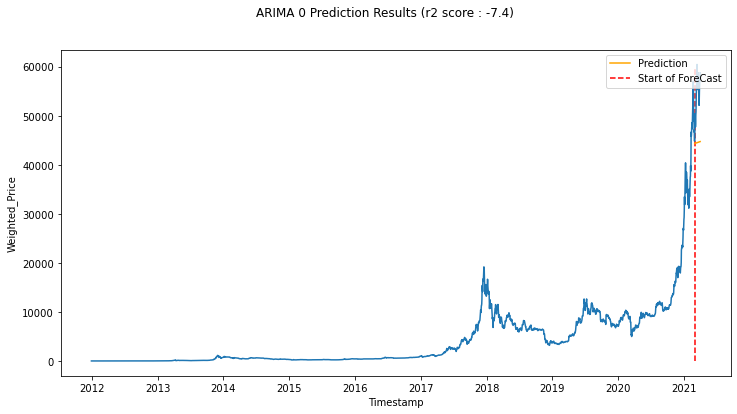

In [177]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', ax=ax)
ax.vlines(datetime(2021,3,1),0,60000, linestyle='--', color='r', label='Start of ForeCast')

ax.plot(predict_index, predicted_value, color='orange', label='Prediction')
plt.legend(loc='upper right')
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Results (r2 score : {round(r2,2)})")

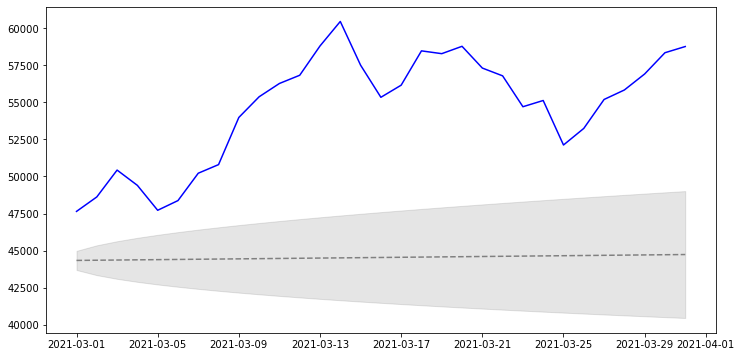

In [178]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, linestyle='--', label='Prediction',color='gray')
ax.plot(btc_daily[predict_index[0]:].index, btc_daily[predict_index[0]:], label='Weighted_Price', color='blue')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')

In [179]:
# SARIMA
# parameter search
print("Examples of parameter combinataions for Seasonal ARIMA")
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order = (i), seasoanl_order = (j))
            model_fit = model.fit()
            print(f"SARIMA : {i}{j} >> AIC {round(model_fit.aic,2)}")
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            pass

Examples of parameter combinataions for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC 48277.66
SARIMA : (0, 1, 2)(0, 1, 1, 12) >

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(1, 1, 0, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(1, 1, 1, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(1, 1, 2, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(2, 1, 0, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC 48279.68
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC 48277.54
SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC 48279.43
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC 48279.43
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC 4

In [180]:
optimal = [params[np.argmin(aic)], min(aic)]
optimal

[((0, 1, 1), (0, 1, 0, 12)), 48275.66]

In [181]:
model_opt = SARIMAX(train.values, order=optimal[0][0], seasonal_order = optimal[0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3345
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood              -25080.351
Date:                             Tue, 12 Oct 2021   AIC                          50164.702
Time:                                     22:09:07   BIC                          50176.925
Sample:                                          0   HQIC                         50169.075
                                            - 3345                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1022      0.005     21.573      0.000       0.093       0.112
sigma2      2.023e+05    836.082    241.927      0.000    2.01e+05    2.04e+05
===================================================================================
Ljung-Box (Q):                     1171.32   Jarque-Bera (JB):            651882.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             796.99   Skew:                            -2.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [183]:
# use model to forecast
prediction = model_opt_fit.get_forecast(len(test))
predicted_value = prediction.predicted_mean
predicted_lb = prediction.conf_int()[:,0]
predicted_ub = prediction.conf_int()[:,1]
predict_index = list(test.index)
r2 = r2_score(test, predicted_value)
r2

-11.924116205329305

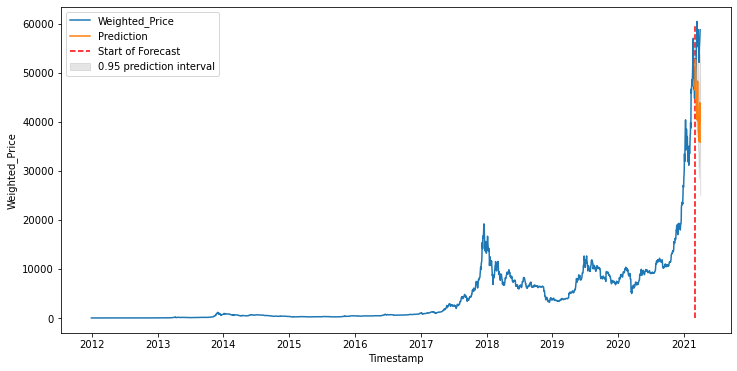

In [188]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', label='Weighted_Price')
ax.vlines(datetime(2021,3,1), 0, 60000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.show()

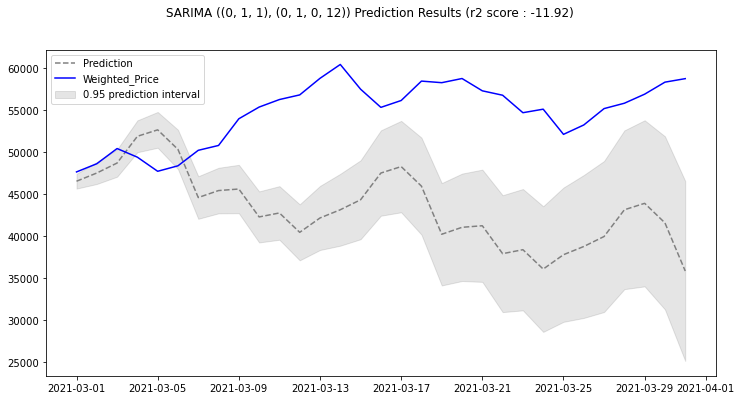

In [187]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, linestyle='--', label='Prediction', color='gray')
ax.plot(btc_daily[predict_index[0]:].index, btc_daily[predict_index[0]:], label='Weighted_Price', color='blue')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.suptitle(f"SARIMA {optimal[0]} Prediction Results (r2 score : {round(r2,2)})")
plt.legend(loc='upper left')